# Link analysis

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import defaultdict
from itertools import combinations
from IPython.core.pylabtools import figsize

## Random directed graph

In [2]:
G = nx.erdos_renyi_graph(10,0.3,directed=True)
A = nx.adj_matrix(G).toarray()

**Assymetric adjacency matrix**

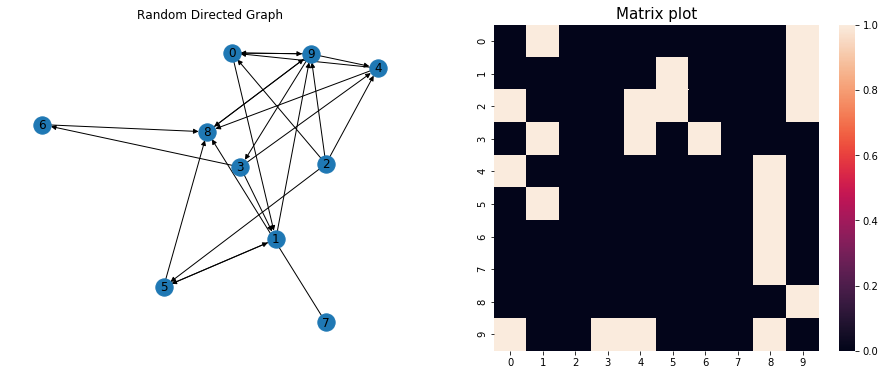

In [3]:
figsize(16,6)
plt.subplot(1,2,1)
nx.draw(G,pos = nx.spring_layout(G),with_labels = True)
plt.title("Random Directed Graph")
plt.subplot(1,2,2)
sns.heatmap(A)
plt.title("Matrix plot",fontsize = 15)
plt.show()

**In-degree matrix and out-degree matrix**

In [4]:
A = nx.adj_matrix(G).toarray()
D_in = np.eye(len(G.nodes)) * list(dict(G.in_degree()).values())
D_out = np.eye(len(G.nodes)) * list(dict(G.out_degree()).values())
D = np.eye(len(G.nodes)) * np.array([d for n, d in nx.degree(G)])

**Which degree matrix?**

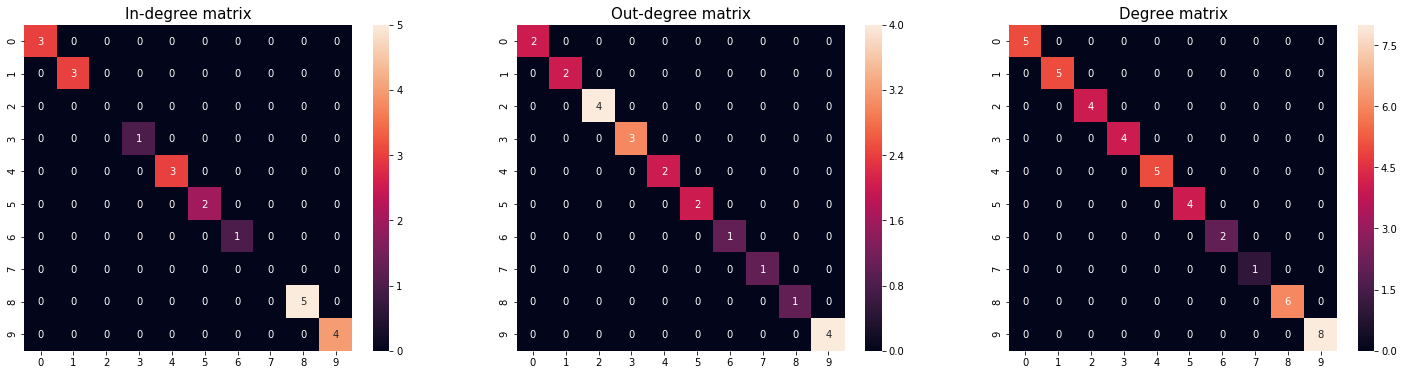

In [5]:
figsize(25,6)
plt.subplot(1,3,1)
sns.heatmap(D_in,annot = True)
plt.title("In-degree matrix",fontsize = 15)
plt.subplot(1,3,2)
sns.heatmap(D_out,annot = True)
plt.title("Out-degree matrix",fontsize = 15)
plt.subplot(1,3,3)
sns.heatmap(D,annot = True)
plt.title("Degree matrix",fontsize = 15)
plt.show()

### Let's rank it

In [6]:
# intialize rank score for each node
r = np.ones(shape = (len(G.nodes),1))

n_epochs = 10
for epoch in range(n_epochs):
    r = np.dot(A.T,r)
    
node_size = r.reshape(-1)/10
node_size.tolist()

[513.8, 451.7, 0.0, 314.6, 453.1, 198.7, 138.5, 0.0, 661.7, 716.1]

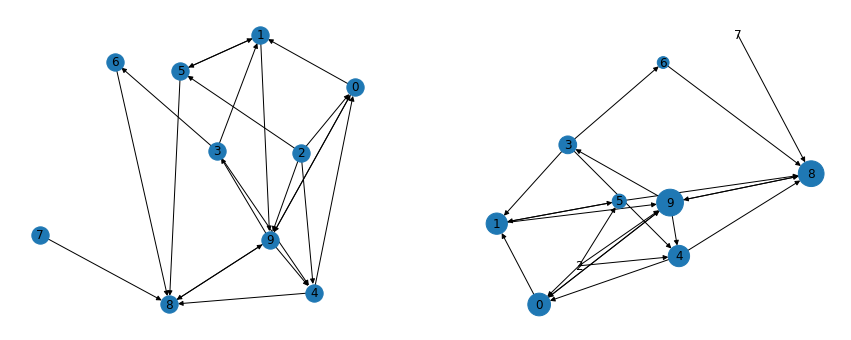

In [7]:
figsize(15,6)
plt.subplot(1,2,1)
nx.draw(G,with_labels = True)
plt.subplot(1,2,2)
nx.draw(G,node_size=node_size,with_labels = True)

**Several problems with this violent ranking**

1. source nodes - (no other nodes point to) will eventually get zero out.
2. absorbing nodes - (nodes not point to any other nodes) will accumalate ranks from neighbors pointing to it.
3. cycles - ranks flow along the cycle path and never converge to a stable status.

## Page Rank

**Random suffer**: a person keeps clicking on links, never hitting back,       
but eventually get board and starts on another random page.       

**Page rank**:The probability of a random suffer visit a page is called page rank

**Edges between pages**:         
gray link: links exist on a webpage        
red link: link by users actually follows(added to existing graph)      

**Use can follow the actual links or jump to any other random links.**


This is acutally randomwalk problem, the **probability of this random walker to visit a page is proportional to pagerank score**.

$PR(A) = (1-d) + d( PR(T1)/C(T1) + PR(T2)/C(T2) +……+ PR(Tn)/C(Tn) )$

**The rank of page A equals sum of 2 parts**:     
- 1 - d: probability of jumping to page A from any random page that not contain a link to page A  **Virtual jump** 
- d * (ranked sum of probabilities from page contain a link to page A)  **Follow a link**


For source nodes in a graph, there is a virtual jump probability.      
For absorbing nodes, there is a virutal jumpy probability to get out.       

## Randomwalk--(probability to be reached)

In [8]:
def generate_strong_connected_DiGraph(n = 10, p=0.3):
    
    '''
        Randomly create a directed graph, if it is strongly connected, return the graph
        A lower value p takes longer time to run
        
        params:
        n - number of nodes
        p = edge connection probability
    '''
    while True:
        try:
            G = nx.erdos_renyi_graph(n,p,directed=True)
            A = nx.adj_matrix(G).toarray()
            D_in = np.eye(len(G.nodes)) * list(dict(G.in_degree()).values())
            D_out = np.eye(len(G.nodes)) * list(dict(G.out_degree()).values())
            D = np.eye(len(G.nodes)) * np.array([d for n, d in nx.degree(G)])
            D_inv_in = np.linalg.inv(D_in)
            D_inv_out =  np.linalg.inv(D_out) 
            break
        except:
            pass
    return G,A,D_in,D_out,D,D_inv_in,D_inv_out

## Walk with accumulation

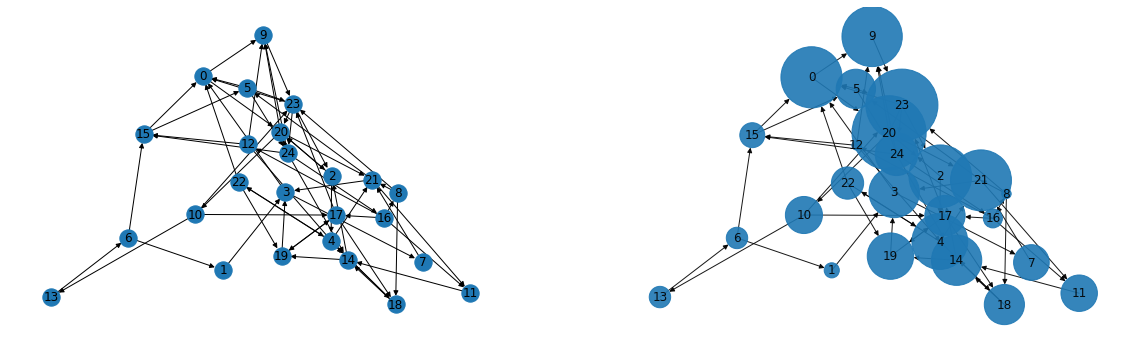

In [9]:
G, A, D_in, D_out, D, D_inv_in, D_inv_out = generate_strong_connected_DiGraph(25,0.08)

# transition matrix
P = np.dot(D_inv_out,A)

# initialized rank vector
p = np.ones((len(G.nodes()),1))

# random walk
for i in range(100):
    p = np.dot(P.T,p)

pos = nx.spring_layout(G)
figsize(20,6)
plt.subplot(1,2,1)
nx.draw(G,with_labels = True,pos = pos)
plt.subplot(1,2,2)
nx.draw(G,node_size=2000*p.reshape(-1),with_labels = True,pos = pos,alpha = 0.9)
plt.show()

## Page Rank Trial

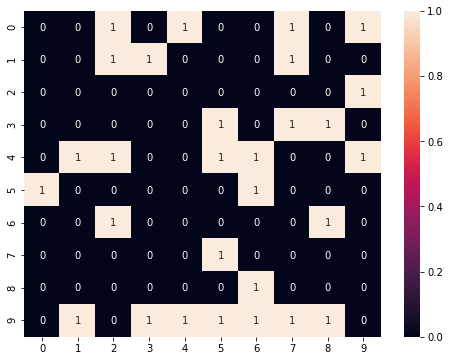

In [10]:
G = nx.erdos_renyi_graph(10,p = .3,directed=True)
figsize(8,6)
sns.heatmap(nx.to_numpy_matrix(G),annot = True)

**Notice the stochastic matrix rows not sum to 1**

1. Stochastic matrix default with a weight
2. Stochastic returns a graph, contain nodes with zero out degree

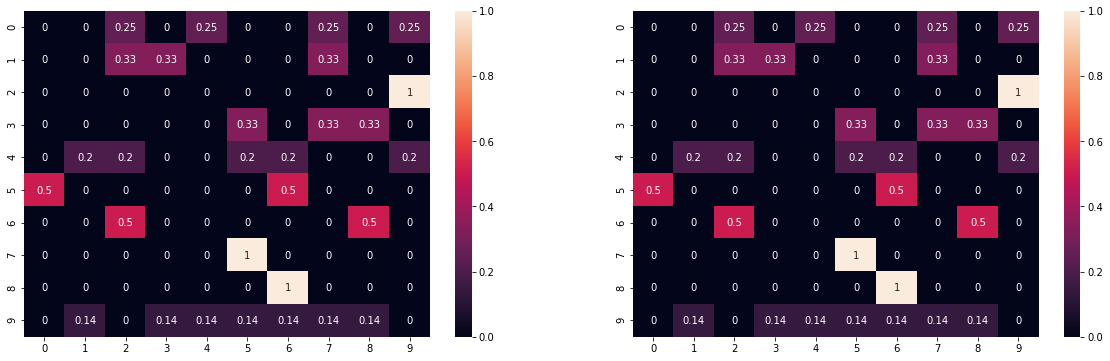

In [11]:
# calculate transition matrix
try:
    D_out = np.eye(len(G)) * list(dict(G.out_degree()).values())
    A = nx.to_numpy_matrix(G)
    P = np.dot(np.linalg.inv(D_out),A)

    figsize(20,6)
    plt.subplot(1,2,1)
    sns.heatmap(P, annot = True)

    plt.subplot(1,2,2)
except:
    pass
# calculate stochastic matrix
sns.heatmap(nx.to_numpy_matrix(nx.stochastic_graph(G)),annot = True)
plt.show()

    personalization: dict, optional
      The "personalization vector" consisting of a dictionary with a
      key for every graph node and nonzero personalization value for each node.
      By default, a uniform distribution is used.

In [15]:
N = len(G)

# normalized personalization
personalization = np.repeat(1./ N,N)

    dangling: dict, optional
      The outedges to be assigned to any "dangling" nodes, i.e., nodes without
      any outedges. The dict key is the node the outedge points to and the dict
      value is the weight of that outedge. By default, dangling nodes are given
      outedges according to the personalization vector (uniform if not
      specified) This must be selected to result in an irreducible transition
      matrix (see notes below). It may be common to have the dangling dict to
      be the same as the personalization dict.

## Page rank implementation (Zhukov Tutorial)

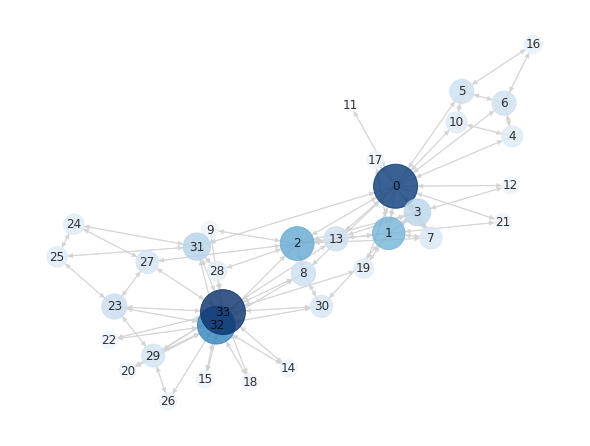

In [160]:
G = nx.erdos_renyi_graph(25,p = .16,directed=True)
G = nx.karate_club_graph().to_directed()

alpha = 0.85
N = len(G)
A = nx.to_numpy_matrix(G)
P = nx.to_numpy_matrix(nx.stochastic_graph(G))
s = (A.sum(axis = 1) == 0).astype(int)
e = np.ones(len(G)).reshape(-1,1)

# add virtual links to sink nodes
p_prime = P + np.dot(s,e.T) / N

# add weight alpha and random connections
google_matrix = alpha * p_prime + (1 - alpha) *  np.dot(e,e.T) / N

# solve eigen vector problem
eigenvalues, eigenvectors = np.linalg.eig(google_matrix.T)
largest_ind = eigenvalues.argsort()[-1]
vector = eigenvectors[:,largest_ind].flatten().real
vector = np.array(vector / vector.sum())[0]

pos = nx.spring_layout(G)
figsize(8,6)
nx.draw(G,
        node_size = vector * 20000,
        with_labels = True,
        pos = pos,
        alpha = 0.8,
        edge_color = 'lightgray',
        node_color = vector,
        cmap = plt.get_cmap("Blues"))